# #30DayMapChallenge
## Day 19: Projections

### Data Source
1. Global Shipping Traffic Density: https://datacatalog.worldbank.org/search/dataset/0037580/Global-Shipping-Traffic-Density
2. Gridded Bathymetry Data: https://www.gebco.net/data-products/gridded-bathymetry-data

### Shipping Traffic

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import rasterio
from rasterio.enums import Resampling
from pyproj import Proj

In [2]:
def from_lonlat_to_spilhaus_xy(longitude, latitude):
    """Transform lon/lat to Spilhaus projection coordinates."""
    e = np.sqrt(0.00669438)
    lat_center_deg = -49.56371678
    lon_center_deg = 66.94970198
    azimuth_deg = 40.17823482
    
    lat_center_rad = np.radians(lat_center_deg)
    lon_center_rad = np.radians(lon_center_deg)
    azimuth_rad = np.radians(azimuth_deg)
    
    conformal_lat_center = -np.pi / 2 + 2 * np.arctan(
        np.tan(np.pi/4 + lat_center_rad/2) *
        ((1 - e * np.sin(lat_center_rad)) / (1 + e * np.sin(lat_center_rad))) ** (e / 2)
    )
    
    alpha = -np.arcsin(np.cos(conformal_lat_center) * np.cos(azimuth_rad))
    lambda_0 = lon_center_rad + np.arctan2(np.tan(azimuth_rad), -np.sin(conformal_lat_center))
    beta = np.pi + np.arctan2(-np.sin(azimuth_rad), -np.tan(conformal_lat_center))
    
    lon = np.radians(longitude)
    lat = np.radians(latitude)
    
    lat_c = -np.pi / 2 + 2 * np.arctan(
        np.tan(np.pi/4 + lat/2) * ((1 - e * np.sin(lat)) / (1 + e * np.sin(lat))) ** (e / 2)
    )
    
    lat_s = np.degrees(np.arcsin(
        np.sin(alpha) * np.sin(lat_c) - np.cos(alpha) * np.cos(lat_c) * np.cos(lon - lambda_0)
    ))
    lon_s = np.degrees(
        beta + np.arctan2(
            np.cos(lat_c) * np.sin(lon - lambda_0), 
            (np.sin(alpha) * np.cos(lat_c) * np.cos(lon - lambda_0) + np.cos(alpha) * np.sin(lat_c))
        )
    )
    
    p = Proj(proj='adams_ws2')
    adams_x, adams_y = p(lon_s, lat_s)
    spilhaus_x = -(adams_x + adams_y) / np.sqrt(2)
    spilhaus_y = (adams_x - adams_y) / np.sqrt(2)
    
    return spilhaus_x, spilhaus_y

In [28]:
# Load and downsample raster
with rasterio.open("shipdensity_global.tif") as src:
    scale = 20
    band1 = src.read(
        1,
        out_shape=(src.height // scale, src.width // scale),
        resampling=Resampling.average
    )
    
    # Update transform for downsampled resolution
    transform = src.transform * src.transform.scale(
        (src.width / band1.shape[-1]),
        (src.height / band1.shape[-2])
    )

In [32]:
# Transform to Spilhaus projection
spilhaus_x, spilhaus_y = from_lonlat_to_spilhaus_xy(lon.flatten(), lat.flatten())

In [34]:
# Prepare data
df = pd.DataFrame({
    "x": spilhaus_x,
    "y": spilhaus_y,
    "z": band1.flatten()
})

# Filter out zero/NaN values
mask = (df["z"] > 0) & (~df["z"].isna())

In [36]:
# Create custom dark blues colormap
blues = plt.cm.Blues
dark_blues = LinearSegmentedColormap.from_list(
    "dark_blues", blues(np.linspace(0.2, 1, 256))
)

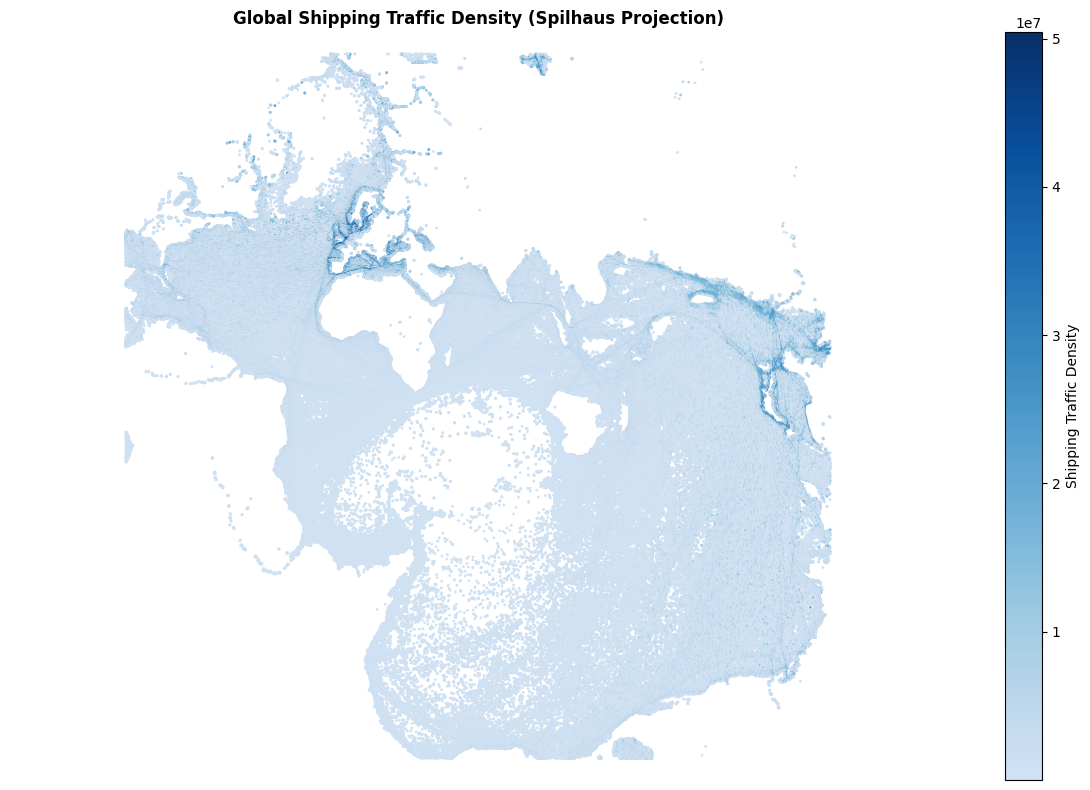

In [38]:
# Plot
plt.figure(figsize=(12, 8))
sc = plt.scatter(
    df.loc[mask, "x"],
    df.loc[mask, "y"],
    c=df.loc[mask, "z"],
    cmap=dark_blues,
    s=1
)
plt.colorbar(sc, label="Shipping Traffic Density")
plt.title("Global Shipping Traffic Density (Spilhaus Projection)", fontweight="bold")
plt.axis("equal")
plt.axis("off")
plt.tight_layout()
plt.show()

### Bathymetry

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# Load GEBCO dataset
nc_file = "GEBCO_2024_sub_ice_topo.nc"
ds = xr.open_dataset(nc_file)

In [9]:
# Downsample cleanly
down_factor = 10
ds_c = ds.coarsen(lon=down_factor, lat=down_factor, boundary="trim").mean()

lon = ds_c["lon"].values
lat = ds_c["lat"].values
elev = ds_c["elevation"].values

In [10]:
# Mask land
ocean = np.where(elev <= 0, elev, np.nan)

# Build coordinate grid
lon_grid, lat_grid = np.meshgrid(lon, lat)

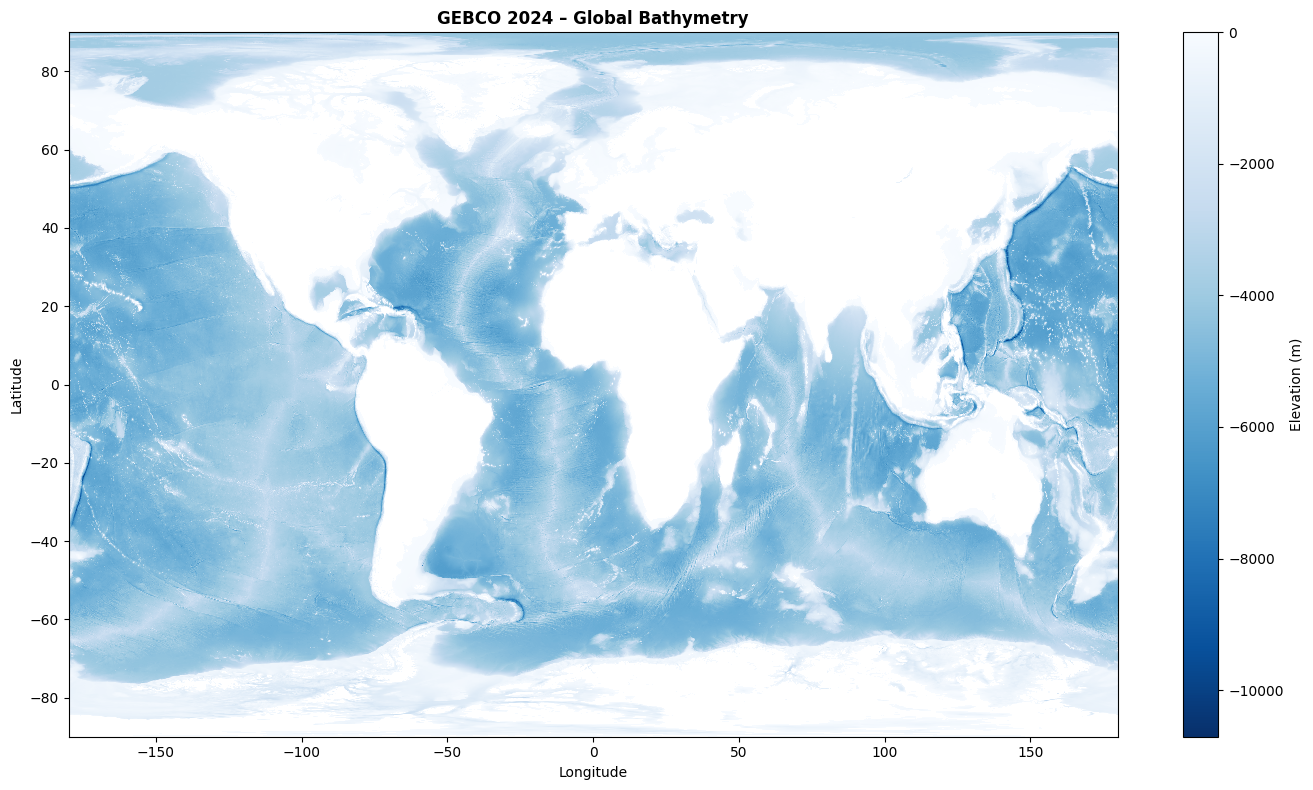

In [80]:
# Plot normal map/no projections
plt.figure(figsize=(14, 8))

plt.pcolormesh(
    lon_grid, lat_grid, ocean,
    cmap="Blues_r",
    shading="auto",
    vmin=np.nanmin(ocean),
    vmax=0
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("GEBCO 2024 – Global Bathymetry", fontweight="bold")
plt.colorbar(label="Elevation (m)")
plt.tight_layout()

# Save the figure
plt.savefig("gebco_bathymetry_normal.png", dpi=300, bbox_inches="tight")

plt.show()

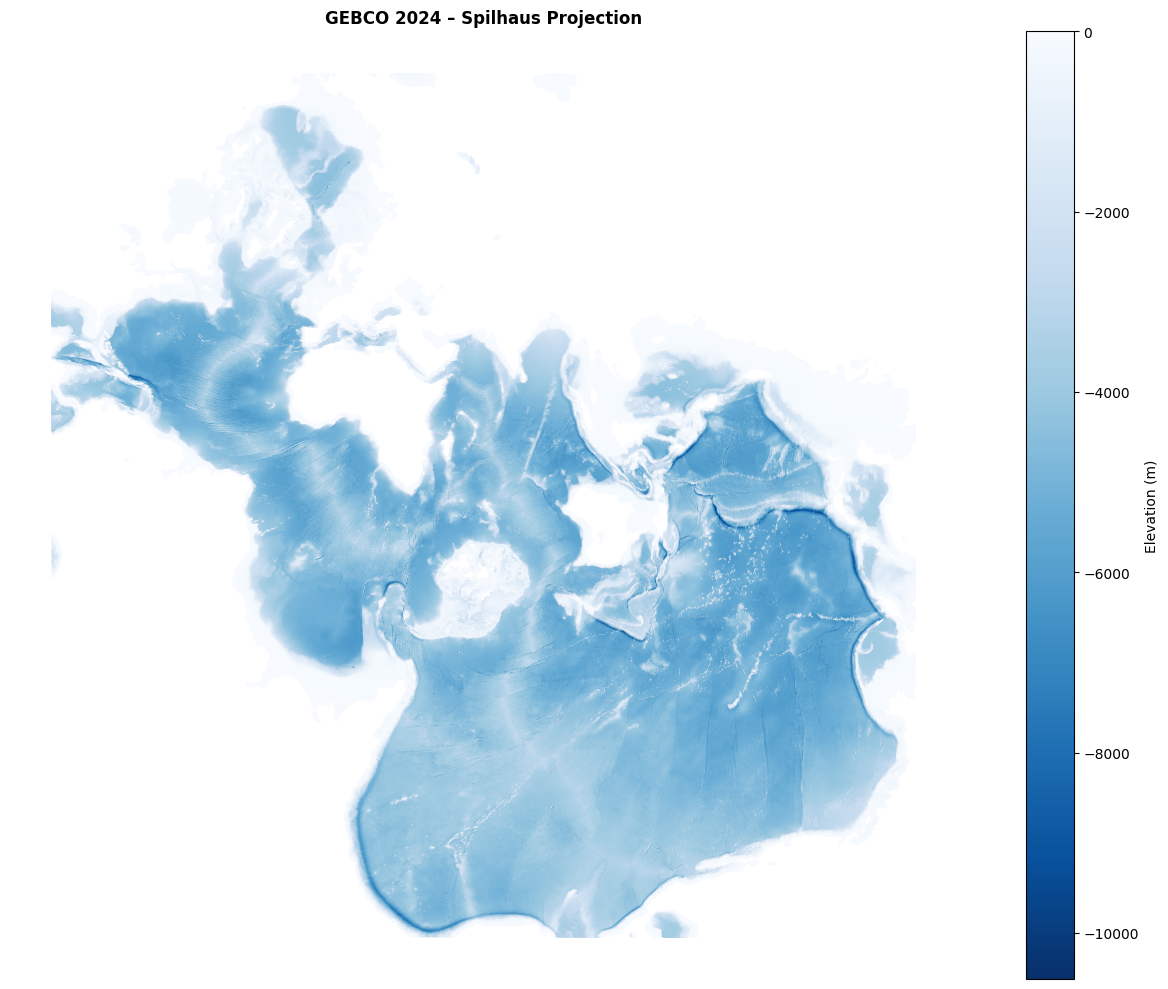

In [11]:
# Spilhaus projection
X, Y = from_lonlat_to_spilhaus_xy(lon_grid.flatten(), lat_grid.flatten())

# Plot figure
plt.figure(figsize=(14, 10))
sc = plt.scatter(
    X, Y,
    c=ocean.flatten(),
    cmap="Blues_r",
    s=1,
    vmin=-10510.5,   
    vmax=0          
)
plt.gca().set_aspect("equal")
plt.axis("off")
cbar = plt.colorbar(sc)
cbar.set_label("Elevation (m)")
plt.title("GEBCO 2024 – Spilhaus Projection", fontweight="bold")
plt.tight_layout()

# Save the figure
plt.savefig("gebco_bathymetry_spilhaus.png", dpi=300, bbox_inches="tight")

plt.show()